# ch8. visualize decision tree
이전 챕터에서 decision tree 기반의 생존 여부 분류 모델을 학습시키고, kaggle에 결과를 제출해보았습니다. 그리고 학습 단계에서 측정한 정확도와 실제로 제출한 모델 사이의 성능이 차이나는 overfitting을 확인했습니다. 학습된 의사 결정 나무를 시각화해보고, 어떤 특징이 생존률 예측 모델에 큰 기여를 했는지 분석해보겠습니다.

### 데이터 셋 준비
미리 전처리 해놓은 데이터 셋을 불러온 뒤, 학습 데이터 셋은 종속 변수와 독립 변수를 분리하겠습니다.

In [1]:
import pandas as pd

train_df = pd.read_csv("./data/preprocessed_train.csv")
test_df = pd.read_csv("./data/preprocessed_test.csv")

예측 모델을 학습시키기 위해선 먼저 예측을 하고자하는 종속 변수와 예측에 사용되는 독립 변수를 분리해주어야 합니다.

In [5]:
y_train = train_df["Survived"]
x_train = train_df.drop(["PassengerId","Survived"], axis=1)
x_test = test_df.drop(["PassengerId"], axis=1)

## Decision Tree 시각화하기
학습된 의사 결정 나무는 시각화할 수 있습니다. 이를 통해 모델이 어떤 식으로 예측을 하는지 해석할 수 있습니다. 그리고 어떤 피쳐가 분기에 사용되었는 지를 알 수 있으며, 이 때의 불순도 역시 알 수 있습니다. 바로 이런 해석 가능성이 의사 결정 나무 모델의 가장 큰 장점입니다. 한번 학습된 모델을 시각화하여 overfitting의 원인을 파악해보겠습니다. 

In [3]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", random_state=1234)
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [7]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt


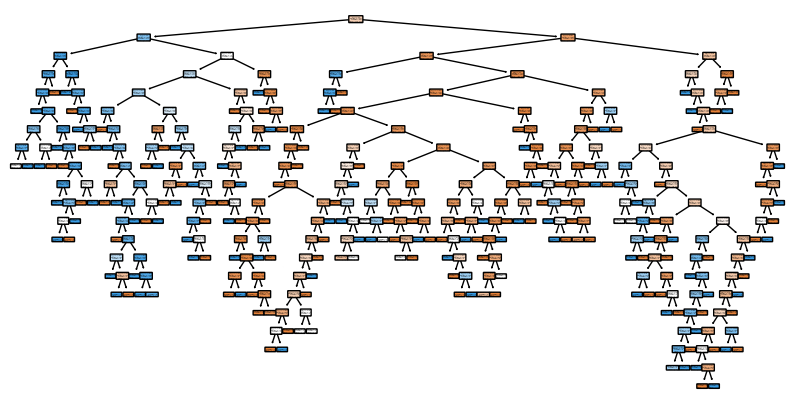

In [11]:
plt.figure(figsize=(10,5))

# 리턴되는 값을 받되 사용하지 않겠다 : 언더바
_ = plot_tree(
    model,
    filled = True,   # 컬러 준 거임 (파랑색: 살 가능성 높은 애들, 빨강: 죽을 가능성 높은 애들)
    rounded = True   # 
)
plt.savefig('foo.png')

시각화 해본 결과 트리가 너무 빽빽하게 생성되었네요. 이런 경우, 학습 데이터 셋에 지나치게 최적화되어 overfitting이 발생하기 쉽습니다. 이번에는 트리의 최대 깊이를 제한하여 학습시킨 다음, 시각화해보겠습니다.

In [12]:
model = DecisionTreeClassifier(
    criterion="entropy",
    random_state=1234,
    max_depth=3
)

model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1234)

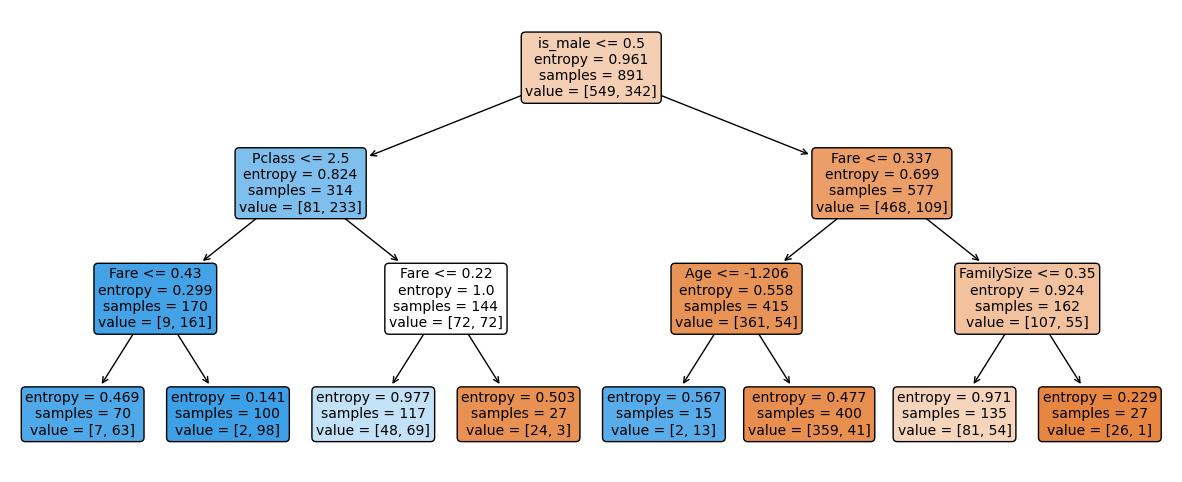

In [18]:
plt.figure(figsize=(15,6))

# 리턴되는 값을 받되 사용하지 않겠다 : 언더바
_ = plot_tree(
    model,
    filled = True,   # 컬러 준 거임 (파랑색: 살 가능성 높은 애들, 빨강: 죽을 가능성 높은 애들)
    rounded = True,
    feature_names= x_train.columns.to_list()
)
plt.savefig('foo.png')

In [1]:
# whitebox model : 해석 가능한 모델 (대표적으로 decision tree)
# blackbox model : 해석 불가능한 모델 (대표적으로 deep learning)

결과를 해석해보자면 가장 먼저 성별을 기준으로 분리를 칩니다. 조건이 True일 때는 왼쪽으로, False일 때는 오른쪽으로 이동합니다. 그러므로 왼쪽이 여성, 오른쪽이 남성입니다. 그 다음은 재귀적으로 분기를 쳐 나갑니다. 3등칸에 탔는지, 운임을 얼만큼 냈는지 등으로 분기를 쳐나갑니다. 리프 노드에 도달하면 죽었는지, 생존했는지를 예측해줍니다.  

### Feature Importance
의사 결정 트리를 시각화하고 해석하는 것 만으로도 예측 모델이 어떻게 동작하는지 파악할 수 있었습니다. 보다 정량적으로 어떤 특징이 얼만큼 예측 모델에 기여했는 지를 알고 싶다면 feature importance를 활용할 수 있습니다.

실제 많이 사용되는 XGBoost나 lightGBM 같은 라이브러리들은 모두 이 feature importance 시각화 함수를 내장화하고 있습니다. scikit-learn에서 제공하는 decision tree는 이를 지원하지 않아서 직접 코드를 작성합니다만, 중요한 부분은 아닙니다.

In [28]:
importance_list = model.feature_importances_

In [29]:
importance_list

array([0.18521645, 0.09350454, 0.        , 0.        , 0.12235405,
       0.03625254, 0.        , 0.56267242, 0.        , 0.        ,
       0.        ])

In [30]:
for i, num in enumerate(list(importance_list)):
    print(i,num)

0 0.18521645097690562
1 0.09350454076280099
2 0.0
3 0.0
4 0.12235405129065856
5 0.03625253856600855
6 0.0
7 0.5626724184036264
8 0.0
9 0.0
10 0.0


In [23]:
import numpy as np

indices = np.argsort(importance_list)
feature_names = x_train.columns.to_list()
sorted_feature_names = [feature_names[x] for x in indices]

In [24]:
indices

array([ 2,  3,  6,  8,  9, 10,  5,  1,  4,  0,  7], dtype=int64)

In [25]:
sorted_feature_names

['SibSp',
 'Parch',
 'IsAlone',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'FamilySize',
 'Age',
 'Fare',
 'Pclass',
 'is_male']

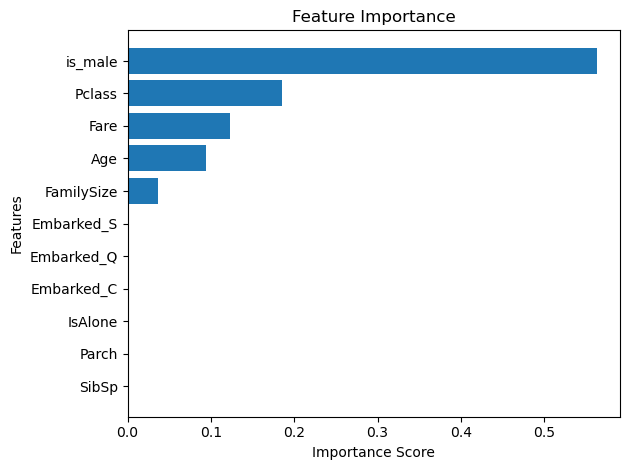

In [27]:
# Create plot
plt.figure()
plt.title("Feature Importance")
ticks = range(len(feature_names))
plt.barh(ticks, importance_list[indices], align="center")
plt.yticks(ticks, sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

feature importance 시각화를 보면 의사 결정 트리를 생성할 때 어떤 피쳐가 많이 기여하였는 지를 한눈에 파악할 수 있습니다. 이를 이용하여 기여도가 낮거나 거의 활용되지 않는 피쳐는 삭제할 수 있습니다. 또한 일일이 corelation을 분석하는 것보다 직관적으로 생존 여부와 관련된 피쳐가 어떤 것들이 있는지 파악할 수 있는 장점이 있습니다.

feature importance를 계산하는 방식은 실제로는 모델마다 다릅니다. 때문에 각 피쳐가 모델 학습에 기여하는 정도를 나타내는 숫자구나 정도로 이해하고, 나중에 정말 필요하다고 생각이 들면 그 때 찾아봐도 괜찮습니다.

## kaggle 제출
decision tree의 max depth를 제한하여 학습시킨 모델로 추론한 결과를 kaggle에 제출해보겠습니다.

In [31]:
y_test = model.predict(x_test)

In [32]:
test_df["Survived"] = y_test

In [33]:
test_df[["PassengerId", "Survived"]].to_csv("./data/submission_limit_max_depth.csv", encoding="utf-8", index=False)

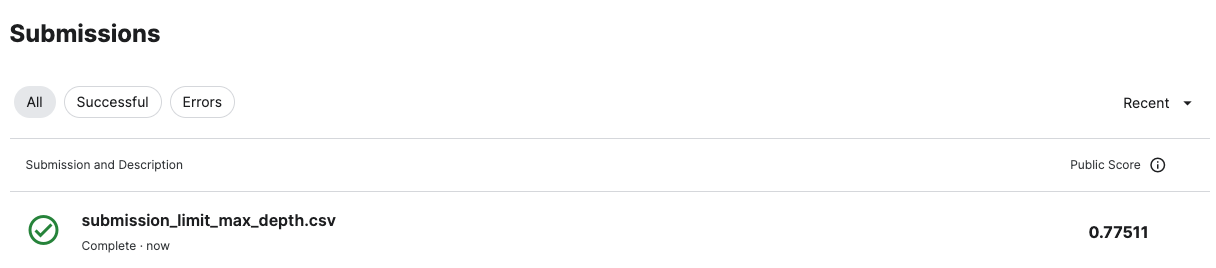

vola! 더 낮은 깊이를 학습시켰음에도 테스트 셋에 대한 정확도가 무려 4%가 상승했습니다. 그리고 무엇보다 validation 과정에서 확인한 정확도와 test set에서의 정확도의 차이가 줄어들었습니다.  깊이가 낮은 더 단순한 decision tree 분류 모델이 학습하지 않은 일반적인 케이스들을 더 잘 예측했다고 볼 수 있습니다.

## 정리
지금까지 기본적은 decision tree 모델을 학습시켜 보았습니다. 그리고 학습된 모델을 시각화하여 모델이 어떤 식으로 생존 여부를 예측하는지 해석해 보았습니다. 그리고 overfitting의 원인을 파악하고, tree의 깊이를 제한하여 학습시킨 다음, 실제로 성능이 향상되는지 확인해보았습니다.

한편 의사 결정 트리 모델을 통해서 데이터에 대해서 더 직관적으로 알게되는 점도 있었습니다. 이렇듯 해석 가능성을 제공하는 decision tree의 강력한 기능을 잘 기억해서 요긴하게 사용하시기 바랍니다.